In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from math import cos, sin, pi
#import contextily as ctx

In [2]:
#data = pd.read_csv('USV_data.csv',skiprows=1)
data = pd.read_csv('https://zenodo.org/records/11124790/files/USV_data.csv?download=1',skiprows=1)
numeric_columns = ['x [m]', 'y [m]', 'xRef [m]', 'yRef [m]', 'alpha [rad]', 'psiRef [rad]', 'psi [rad]',
                   'USV speed [m/s]', 'course angle [rad]', 'Sampling time [sec]', 'latRef', 'lonRef',
                   'latGps', 'lonGps']
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')
data.columns
x = data['x [m]'].values
y = data['y [m]'].values
xRef = data['xRef [m]'].values
yRef = data['yRef [m]'].values
alpha = data['alpha [rad]'].values
psiRef = data['psiRef [rad]'].values
psi = data['psi [rad]'].values
U = data['USV speed [m/s]'].values
course = data['course angle [rad]'].values
dt = data['Sampling time [sec]'].values[0]
latRef = data['latRef'].values
lonRef = data['lonRef'].values
latGps = data['latGps'].values
lonGps = data['lonGps'].values
print(dt)

0.1


In [3]:
# Initialisation
Pc = np.eye(2)
xc = np.zeros((2, len(x)))
xp = np.zeros((2, len(x)))
beta_hat = np.zeros(len(xc[1]))
ye = np.zeros(len(xc[1]))

In [4]:
Pc = np.eye(2)
xc = np.zeros((2, len(x)))
xp = np.zeros((2, len(x)))
beta_hat = np.zeros(len(xc[1]))
for n in range(1, len(x)):
    beta_gps = np.unwrap([course[n] - psi[n]])
    Rd = [100]
    Q22 = 0.1
    Qd = np.diag([10, Q22])
    Ad = np.array([[1, dt * U[n] * cos(psi[n] - alpha[n])], [0, 1]])
    Bd = np.array([[U[n] * sin(psi[n] - alpha[n])], [0]]) * dt
    Cd = np.array([1, 0]).reshape(1, 2)
    xp[:, n]  = (Ad @ xc[:, n - 1] + Bd.T)
    Pp = Ad @ Pc @ Ad.T + Qd
    ye[n] = - (x[n] - xRef[n]) * sin(alpha[n]) + (y[n] - yRef[n]) * cos(alpha[n])
    K = (Pp @ Cd.T / (Cd @ Pp @ Cd.T + Rd)).reshape(-1, 1)
    Pc = (np.eye(2) - K @ Cd) @ Pp
    temp=K * np.array(ye[n] - Cd @ xp[:,n])
    xc[:, n] = xp[:,n] + temp.T
    beta_hat[n] = xc[1, n]

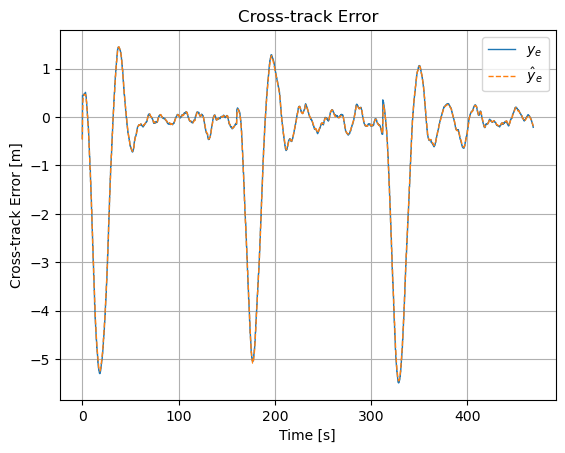

In [5]:
# Plotting and visualization
T = len(ye)
interval = range(32782, 37468)  # plotting interval
T1=len(interval)
plt.figure()
plt.plot(np.arange(T1) * dt, ye[interval], linewidth=1, label='$y_e$')
plt.plot(np.arange(T1) * dt, xc[0, interval], '--', linewidth=1, label='$\hat y_e$')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Cross-track Error [m]')
plt.grid(True)
plt.title('Cross-track Error')
plt.show()

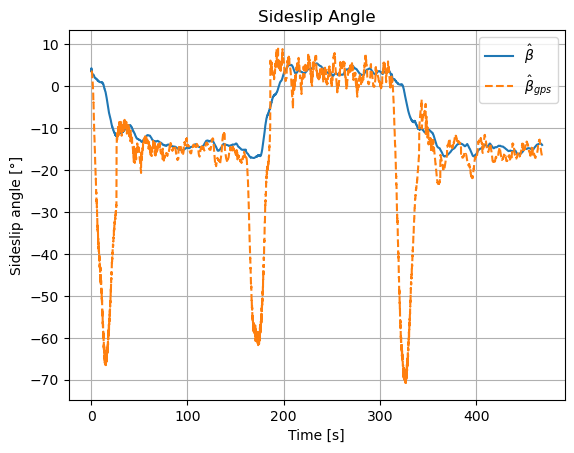

In [6]:
plt.figure()
plt.plot(np.arange(T1) * dt, beta_hat[interval] * 180 / pi, label=r'$\hat \beta$')
plt.plot(np.arange(T1) * dt, (np.unwrap(course[interval] -  psi[interval])-2*pi)*180/pi, '--', label=r'$\hat \beta_{gps}$')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Sideslip angle [°]')
plt.grid(True)
plt.title('Sideslip Angle')
plt.show()

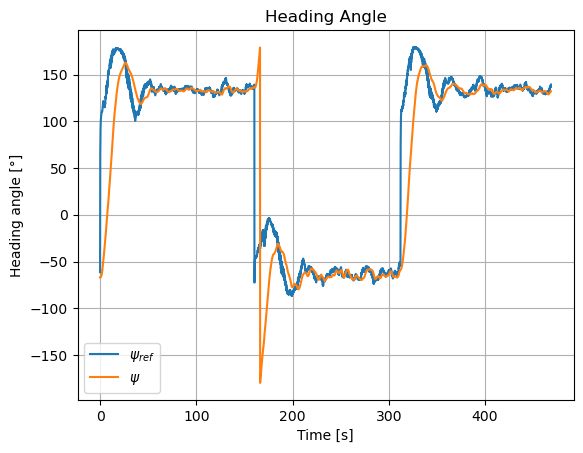

In [7]:
plt.figure()
plt.plot(np.arange(T1) * dt, (psiRef[interval]) * 180 / pi, label=r'$\psi_{ref}$')
plt.plot(np.arange(T1) * dt, (psi[interval]) * 180 / pi, label=r'$\psi$')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel('Heading angle [°]')
plt.grid(True)
plt.title('Heading Angle')
plt.show()

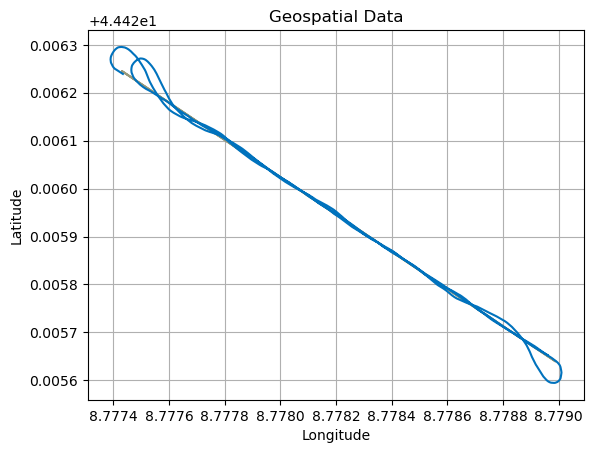

In [8]:
# Plot geospatial data
plt.figure()
plt.plot(lonRef, latRef, color=[0.6, 0.6, 0.48])
plt.plot(lonGps[interval], latGps[interval], color=[0, 0.4470, 0.7410])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.title('Geospatial Data')
plt.show()